# Fasttext

In [1]:
%matplotlib inline

import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
import ktrain
from ktrain import text

## Build test and training sets & define preprocessing

In [3]:
NUM_WORDS = 50000
MAXLEN = 1000
NGRAM_RANGE = 1

In [4]:
train, test, preproc = text.texts_from_csv('../data/train.csv',
                                          'cleaned_contents',
                                          label_columns=['Discrimination_Label'],
                                          val_filepath='../data/test.csv',
                                          max_features=NUM_WORDS,
                                          maxlen=MAXLEN,
                                          ngram_range=NGRAM_RANGE)

detected encoding: utf-8 (if wrong, set manually)
language: en
Word Counts: 17751
Nrows: 647
647 train sequences
train sequence lengths:
	mean : 1526
	95percentile : 4005
	99percentile : 7619
x_train shape: (647,1000)
y_train shape: (647, 2)
Is Multi-Label? False
162 test sequences
test sequence lengths:
	mean : 1414
	95percentile : 3320
	99percentile : 7203
x_test shape: (162,1000)
y_test shape: (162, 2)


## Define and train the model

In [5]:
model = text.text_classifier('fasttext', train, preproc=preproc)
learner = ktrain.get_learner(model, train_data=train, val_data=test)

Is Multi-Label? False
compiling word ID features...
maxlen is 1000
done.


In [6]:
learner.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 64)          3200000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1000, 64)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

### Find a good initial learning rate

This is a method that was developed at the Naval Research Laboratory.  It's been promoted by Jeremy Howard.

simulating training for different learning rates... this may take a few moments...
Train on 647 samples
Epoch 1/5


/usr/local/lib/python3.6/dist-packages/ktrain/core.py:476: UserWarning: max_epochs is being set to 5 since steps per epoch is small. If you wish to estimate LR using more epochs, set max_epochs manually.
  'If you wish to estimate LR using more epochs, set max_epochs manually.')


647/647 [==============================] - 2s 2ms/sample - loss: 0.9779 - accuracy: 0.5379
Epoch 2/5
647/647 [==============================] - 1s 819us/sample - loss: 0.9450 - accuracy: 0.5193
Epoch 3/5
647/647 [==============================] - 0s 770us/sample - loss: 0.9212 - accuracy: 0.5270
Epoch 4/5
647/647 [==============================] - 1s 795us/sample - loss: 0.9279 - accuracy: 0.5286
Epoch 5/5
352/647 [===============>..............] - ETA: 0s - loss: 1.9160 - accuracy: 0.5426

done.
Visually inspect loss plot and select learning rate associated with falling loss


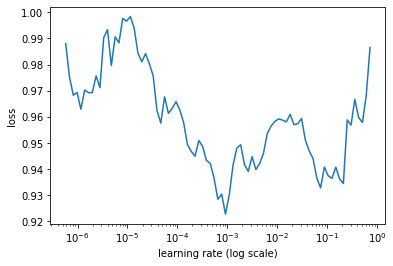

In [7]:
learner.lr_find(show_plot=True)

### Train

In [8]:
learner.autofit(2e-2, early_stopping=5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.02...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 1s 2ms/sample - loss: 0.9146 - accuracy: 0.5317 - val_loss: 0.6981 - val_accuracy: 0.4136
Epoch 2/1024
647/647 [==============================] - 1s 925us/sample - loss: 0.7763 - accuracy: 0.5332 - val_loss: 0.6909 - val_accuracy: 0.6049
Epoch 3/1024
647/647 [==============================] - 1s 902us/sample - loss: 0.7056 - accuracy: 0.5564 - val_loss: 0.6852 - val_accuracy: 0.6358
Epoch 4/1024
647/647 [==============================] - 1s 878us/sample - loss: 0.6878 - accuracy: 0.5796 - val_loss: 0.6707 - val_accuracy: 0.5988
Epoch 5/1024
647/647 [==============================] - 1s 860us/sample - loss: 0.6701 - accuracy: 0.6090 - val_loss: 0.6778 - val_accuracy: 0.6481
Epoch 6/1024
640/647 [============================>.] - ETA: 0s - loss: 0.6303 - acc

## Examine results

In [9]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

           0       0.68      0.58      0.63        65
           1       0.75      0.81      0.78        97

    accuracy                           0.72       162
   macro avg       0.71      0.70      0.70       162
weighted avg       0.72      0.72      0.72       162



array([[38, 27],
       [18, 79]])

## Explain a prediction

In [10]:
import pandas as pd
X_test = pd.read_csv('../data/test.csv')['cleaned_contents']

In [11]:
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [12]:
predictor.explain('As the accused is the sole breadwinner for his family, I reduce his sentence by two years.')